# Final Model Notebook

In this notebook, I will create final models of my data, calculating both the average annual and monthly sales price of grain corn.

This notebook is running on a standard `Python 3` kernel.

In [1]:
# Import tools and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
import math

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import linregress

Some of my methods will throw up warnings. I will silence these warnings to improve readablity of the notebook.

In [2]:
import warnings
warnings.filterwarnings('ignore')

I will import the annual corn data and confirm that it imports correctly.

In [53]:
# Import national year csv file and convert to a dataframe
nat_year = pd.read_csv('./nat_year.csv', index_col=0, thousands=',')

# confirm import was successful
nat_year.tail(20)

,Year,"PRICE RECEIVED, MEASURED IN $ / BU",ACRES HARVESTED,"PRODUCTION, MEASURED IN BU","YIELD, MEASURED IN BU / ACRE","PRODUCTION, MEASURED IN $",Cooling Degree Days,Heating Degree Days,Precipitation,Palmer Drought Severity Index (PDSI),Palmer Hydrological Drought Index (PHDI),Palmer Modified Drought Index (PMDI),Average Temperature,Maximum Temperature,Minimum Temperature,Palmer Z-Index,USPop
51,2001,1.89,68768000,9502580000,138.2,18878819000,306,10,29.02,-2.55,-2.55,-2.45,53.69,65.64,41.74,-0.52,284970000
52,2002,2.13,69330000,8966787000,129.3,20882448000,365,3,29.05,-3.56,-3.56,-3.56,53.21,65.19,41.22,-1.70,287630000
53,2003,2.27,70944000,10087292000,142.2,24472254000,335,5,30.51,1.60,1.60,1.60,53.26,65.11,41.40,0.45,290110000
54,2004,2.47,73631000,11805581000,160.3,24377913000,297,9,33.25,1.50,1.50,1.50,53.10,64.61,41.57,2.16,292810000
55,2005,1.96,75117000,11112187000,147.9,22194287000,367,4,30.08,0.11,2.44,1.82,53.64,65.49,41.78,-0.22,295520000
56,2006,2.28,70638000,10531123000,149.1,32083011000,383,3,29.82,-3.65,-3.65,-3.65,54.25,66.41,42.08,-3.03,298380000
57,2007,3.39,86520000,13037875000,150.7,54666959000,308,6,29.18,-1.55,-1.55,-0.91,53.65,65.64,41.67,-0.41,301230000
58,2008,4.78,78570000,12043203000,153.3,49104148000,331,6,31.24,0.72,0.72,0.72,52.29,64.45,40.13,0.44,304090000
59,2009,3.75,79490000,13067156000,164.4,46640936000,286,15,32.30,1.18,1.18,1.18,52.39,64.17,40.60,1.71,306770000
60,2010,3.83,81446000,12425330000,152.6,64529628000,375,6,31.37,3.48,3.48,3.48,52.98,64.66,41.31,2.30,309320000


The data frame has imported successfully. I will now plot the target columns vs the `Year` column. Target columns include:
- `PRICE RECEIVED, MEASURED IN $ / BU`
- `ACRES HARVESTED`
- `PRODUCTION, MEASURED IN BU`
- `YIELD, MEASURED IN BU / ACRE`
- `PRODUCTION, MEASURED IN $`

I will first sperate these into X and y components

In [4]:
# y is the target features
y = nat_year[['PRODUCTION, MEASURED IN BU', 'PRODUCTION, MEASURED IN $', 'YIELD, MEASURED IN BU / ACRE', 'PRICE RECEIVED, MEASURED IN $ / BU', 'ACRES HARVESTED']]

# X is all other features
X = nat_year.drop(columns=y.keys())

I will then plot the `y` values vs year to look for any obvious trends. 

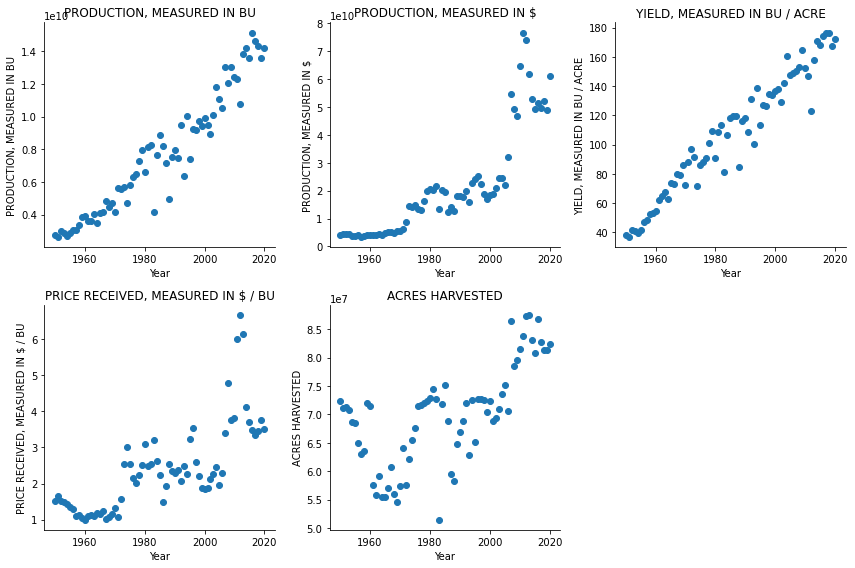

In [31]:
plt.subplots(5, figsize=(12,8))

n=1
for column in y:
    plt.subplot(2,3,n)
    plt.scatter(nat_year['Year'], y[column], label=column)
    plt.xlabel('Year')
    plt.ylabel(column)
    plt.title(column)
    n += 1


plt.tight_layout()
sns.despine()
plt.show()

Both the `PRODUCTION, MEASURED IN BU` and `YIELD, MEASURED IN BU / ACRE` columns appear to be highly linear with year. The acres harvested in a year appear to be dependent on the price recieved per bushel in the previous year. I am, therefore, going to create a new column holding the price from the previous year.

In [6]:
# Creating the new column. I am setting all values equal to 0.0 to set the column type as a float.
X['Previous_Year_Price_Recieved'] = 0.0

# Populating column.
# Note: I have to start with the second row, as the price recieved in the year prior to 1950 is not available.
# Thus, the value for this column for the year 1950 will be 0.
for ind in range(1,71):
    X['Previous_Year_Price_Recieved'][ind] = nat_year['PRICE RECEIVED, MEASURED IN $ / BU'][ind - 1]
    
# Confirm the column was created successfully.
X.head()

,Year,"PRICE RECEIVED, MEASURED IN $ / BU",ACRES HARVESTED,"PRODUCTION, MEASURED IN BU","YIELD, MEASURED IN BU / ACRE","PRODUCTION, MEASURED IN $",Cooling Degree Days,Heating Degree Days,Precipitation,Palmer Drought Severity Index (PDSI),Palmer Hydrological Drought Index (PHDI),Palmer Modified Drought Index (PMDI),Average Temperature,Maximum Temperature,Minimum Temperature,Palmer Z-Index,USPop
0,1950,1.52,72398000,2764071000,38.2,4222366000,263,14,30.87,1.93,1.93,1.93,51.39,63.61,39.17,4.14,152270000
1,1951,1.66,71191000,2628937000,36.9,4364659000,314,9,31.25,1.65,1.65,1.65,51.12,63.19,39.04,0.80,154880000
2,1952,1.52,71353000,2980793000,41.8,4557031000,355,6,26.34,-1.84,-1.84,-1.84,52.27,64.70,39.85,-2.32,157550000
3,1953,1.48,70738000,2881801000,40.7,4291366000,330,7,28.31,-1.76,-1.76,-0.88,53.37,65.76,40.96,-0.43,160180000
4,1954,1.43,68668000,2707913000,39.4,3872433000,349,10,26.15,-4.33,-4.33,-4.33,53.33,65.78,40.87,-2.76,163030000


The new feature was created successfully. I will now plot the acres harvested per year vs this new feature. 

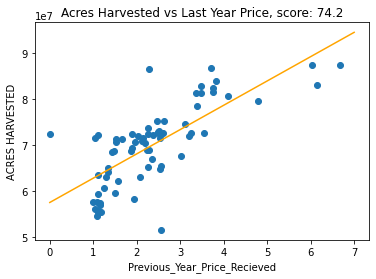

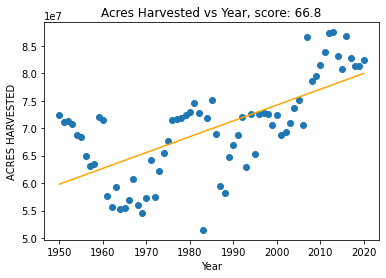

In [7]:
# Calculate linear regression stats for the plot
slope, intercept, r_value, p_value, std_err = linregress(X['Previous_Year_Price_Recieved'], y['ACRES HARVESTED'])
x_range = np.arange(0,8)

plt.figure()
plt.scatter(X['Previous_Year_Price_Recieved'], y['ACRES HARVESTED'])
plt.plot(x_range, slope*x_range + intercept, color='orange')
plt.ylabel('ACRES HARVESTED')
plt.xlabel('Previous_Year_Price_Recieved')
plt.title(f"Acres Harvested vs Last Year Price, score: {round(r_value*100,1)}")
plt.show()

# Calculate linear regression stats for the plot
slope, intercept, r_value, p_value, std_err = linregress(X['Year'], y['ACRES HARVESTED'])
x_range = np.arange(1950,2021)

plt.figure()
plt.scatter(X['Year'], y['ACRES HARVESTED'])
plt.plot(x_range, slope*x_range + intercept, color='orange')
plt.ylabel('ACRES HARVESTED')
plt.xlabel('Year')
plt.title(f"Acres Harvested vs Year, score: {round(r_value*100,1)}")
plt.show()

A significant improvement in the ability to predict the number of acres harvested per year is obtained. When simply using the year, only about 2/3 of the variation is accounted for. When using last year's price, about 3/4 of the variation is accounted for.

I now want to determine which features are highly correlated with the target features. I will determine the correlation for all of these features and only keep features with a correlation of greater than 0.5 or less than -0.5.

In [8]:
# Create a list for the highly correlated features I want to keep.
keeper_list = list()

# Iterate through the features in y
for column_y in y:
    
    # On that y feature, itterate through the features in X
    for column_x in X:
        
        # If the correlation between the y feature and X feature is in the acceptable ranges,
        # add the X feature to the keeper_list. 
        if (y[column_y].corr(X[column_x]) > 0.5) | (y[column_y].corr(X[column_x]) < -0.5):
            keeper_list.append(column_x)

# Filter the high correlation list for unique values()
keeper_list = set(keeper_list)

print(keeper_list)

{'Previous_Year_Price_Recieved', ' Cooling Degree Days', ' Minimum Temperature', 'USPop', ' Average Temperature', 'Year'}


There are six high correlation features:
- `Minimum Temperature`
- `Cooling Degree Days`
- `Year`
- `USPop`
- `Previous_Year_Price_Recieved`
- `Average Temperature`  

I will now filter the X data frame so that it only retains these high correlation features.

In [9]:
# Reduce X to only containing the high correlation features
X = X[keeper_list]

# Confirm X has only the proper columns
X

,Previous_Year_Price_Recieved,Cooling Degree Days,Minimum Temperature,USPop,Average Temperature,Year
0,0.00,263,39.17,152270000,51.39,1950
1,1.52,314,39.04,154880000,51.12,1951
2,1.66,355,39.85,157550000,52.27,1952
3,1.52,330,40.96,160180000,53.37,1953
4,1.48,349,40.87,163030000,53.33,1954
...,...,...,...,...,...,...
66,3.71,381,43.13,322940000,54.92,2016
67,3.48,359,42.74,324990000,54.55,2017
68,3.36,372,41.94,326690000,53.52,2018
69,3.47,370,41.27,328240000,52.68,2019


X has been modified properly. I will now try modelling the y values as a function of the X values using both linear regression and K nearest neighbors.

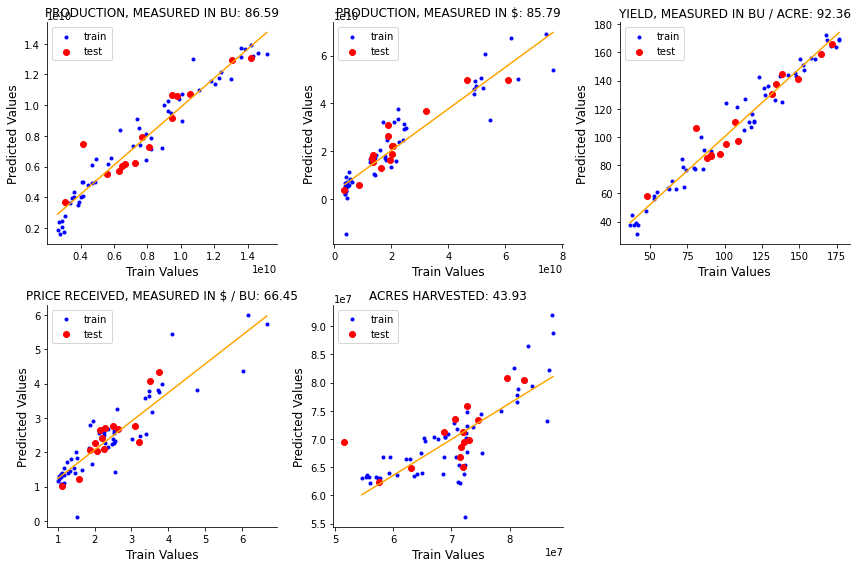

In [101]:
# Linear models

# Create a subplot figure
plt.subplots(5, figsize=(12,8))

# Create lists to store results from the following for loop
y_test_values = list()
y_pred_values = list()
y_year = list()

# Set a counter for which subplot we are on
n = 1

# Iterate through target features
for column in y:
    
    # Split the data into train and test sets. 
    X_train, X_test, y_train, y_test = train_test_split(X, y[column], test_size=0.2, random_state=0)
    
    # Add the y test values to to the test value list
    y_test_values.append(y_test)
    
    # Create the linear model
    lin_reg = LinearRegression()
    
    # Fit the model to the train data
    lin_reg.fit(X_train, y_train)
    
    # Predict y values for the train and tes data
    y_pred = lin_reg.predict(X_train)
    y_test_pred = lin_reg.predict(X_test)
    
    # Get the indeces for the y_test values so that the y_test_pred values can have the same index
    y_test_index = y_test.index.tolist()
    
    # Turn the y_test_pred values into a pandas series for later ease of analysis
    y_test_pred_series = pd.Series(y_test_pred, index=y_test_index, name=column)
    
    # Add predicted test values to the y_pred_values list
    y_pred_values.append(y_test_pred_series)
    
    # Calculate linear regression stats between the y train values and predicted y train values
    slope, intercept, r_value, p_value, std_err = linregress(y_train, y_pred)
    
    #calculate a range of values to model as the X axis for a best fit line
    min_y = y_train.min()
    max_y = y_train.max()
    scale = (max_y - min_y) / 2
    x_range = np.arange(min_y, max_y+1, scale)
    
    # Plot the data with a best fit line and a title including the model score for the test values
    plt.subplot(2,3,n)
    plt.scatter(y_train, y_pred, label='train', color='blue', marker='.')
    plt.scatter(y_test, y_test_pred, label='test', color='red')
    plt.plot(x_range, slope*x_range + intercept, color='orange')
    plt.xlabel('Train Values', size=12)
    plt.ylabel('Predicted Values', size=12)
    plt.title(column + ": " + str(round(100*lin_reg.score(X_test, y_test),2)))
    plt.legend()
    sns.despine()
    plt.tight_layout()
    
    # Increase the subplot counter
    n += 1

    
plt.tight_layout()    
plt.show()

Fairly decent scores (>85%) are obtained for the targets `PRODUCTION, MEASURED IN BU`, `PRODUCTION, MEASURED IN $`, and `YIELD, MEASURED IN BU / ACRE`. However, significantly lower scores (<70%) were obtained for `PRICE RECEIVED, MEASURED IN $ / BU` and `ACRES HARVESTED`.  

I will now create a K nearest neighbor model for these data to see how it compares in performance.

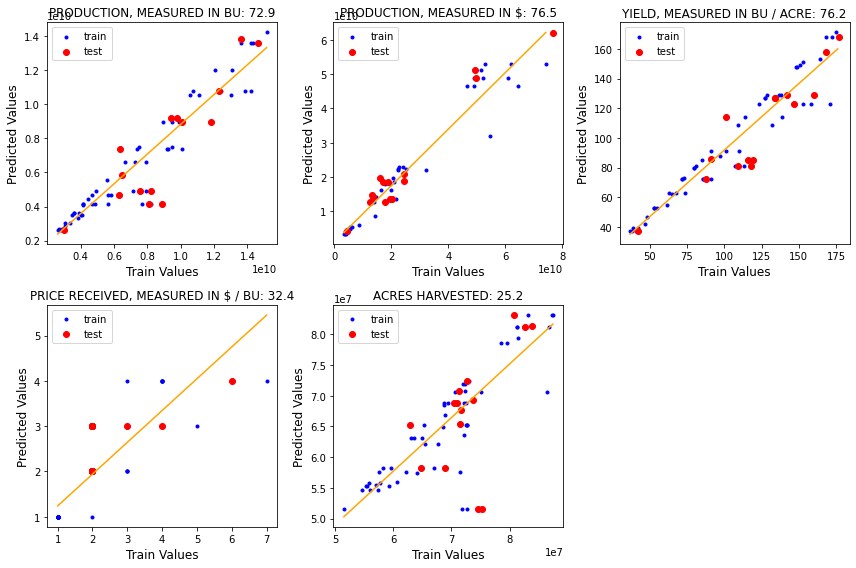

In [11]:
# Create a subplot figure
plt.subplots(5, figsize=(12,8))

# Set a counter for which subplot we are on
n = 1

# Iterate through the target features
for column in y:
    
    # KNN requires all data to be integer values. 
    # So, if a column contains non-integer values, I will round the data in that column to the
    # nearest whole numerb and then cast the column as a float.
    if y[column].dtypes == 'int64':
        y_data = y[column]
    else:
        y_data = y[column].round().astype('int64')
    
    # Split the data into train and test sets. 
    X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.2, random_state=1)
    
    # Instantiate the KNN model with 3 nearest neighbors
    KNN_reg = KNeighborsClassifier(n_neighbors=3)
    
    # Fit the model with the train data
    KNN_reg.fit(X_train, y_train)
    
    # KNN is only able to calculate a score vs categorical columns. 
    # Since I am working with continous data, I will also create a linear model
    # fitted to the train data for score assessment.
    lin_reg = LinearRegression().fit(X_train, y_train)

    # Predict y values for the train and tes data
    y_pred = KNN_reg.predict(X_train)
    y_test_pred = KNN_reg.predict(X_test)
    
    # Calculate linear regression stats between the y train values and predicted y train values
    slope, intercept, r_value, p_value, std_err = linregress(y_train, y_pred)
    
    #calculate a range of values to model as the X axis for a best fit line
    min_y = y_train.min()
    max_y = y_train.max()
    scale = (max_y - min_y) / 2
    x_range = np.arange(min_y, max_y+1, scale)
    
     # Plot the data with a best fit line and a title including the model score for the test values
    plt.subplot(2,3,n)
    plt.scatter(y_train, y_pred, label='train', color='blue', marker='.')
    plt.scatter(y_test, y_test_pred, label='test', color='red')
    plt.plot(x_range, slope*x_range + intercept, color='orange')
    plt.xlabel('Train Values', size=12)
    plt.ylabel('Predicted Values', size=12)
    plt.title(column + ": " + str(round(100*lin_reg.score(X_test, y_test_pred),1)))
    plt.legend()
    
    # Increase the subplot counter
    n += 1
    
plt.tight_layout()    
plt.show()

Nearly all of the scores obtained with the KNN model using 3 nearest neighbors are significantly lower (most are more than 10 points lower) than the scores obtained with the linear model. I will try a KNN model one more time using only 1 nearest nieghbor to see if better performance can be obtained.

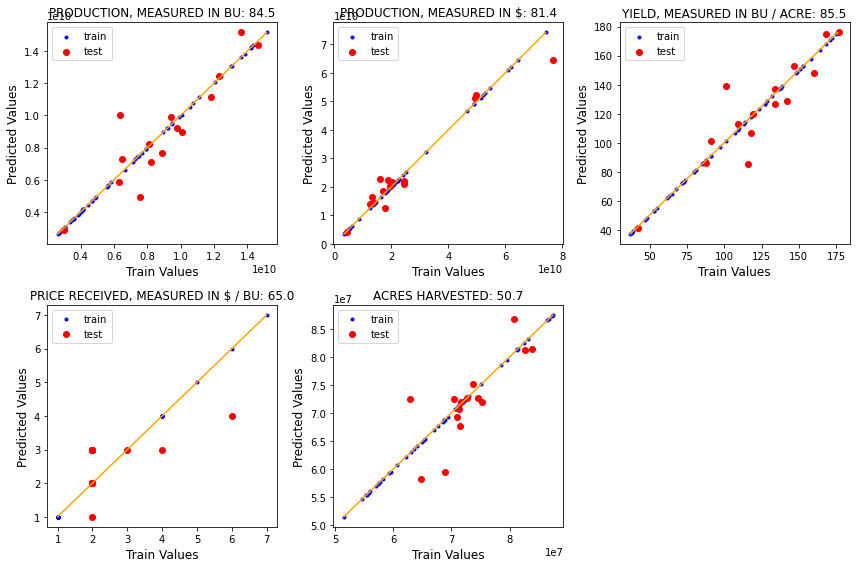

In [12]:
# Create a subplot figure
plt.subplots(5, figsize=(12,8))

# Set a counter for which subplot we are on
n = 1

# Iterate through the target features
for column in y:
    
    # KNN requires all data to be integer values. 
    # So, if a column contains non-integer values, I will round the data in that column to the
    # nearest whole numerb and then cast the column as a float.
    if y[column].dtypes == 'int64':
        y_data = y[column]
    else:
        y_data = y[column].round().astype('int64')
    
    # Split the data into train and test sets. 
    X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.2, random_state=1)
    
    # Instantiate the KNN model with 3 nearest neighbors
    KNN_reg = KNeighborsClassifier(n_neighbors=1)
    
    # Fit the model with the train data
    KNN_reg.fit(X_train, y_train)
    
    # KNN is only able to calculate a score vs categorical columns. 
    # Since I am working with continous data, I will also create a linear model
    # fitted to the train data for score assessment.
    lin_reg = LinearRegression().fit(X_train, y_train)

    # Predict y values for the train and tes data
    y_pred = KNN_reg.predict(X_train)
    y_test_pred = KNN_reg.predict(X_test)
    
    # Calculate linear regression stats between the y train values and predicted y train values
    slope, intercept, r_value, p_value, std_err = linregress(y_train, y_pred)
    
    #calculate a range of values to model as the X axis for a best fit line
    min_y = y_train.min()
    max_y = y_train.max()
    scale = (max_y - min_y) / 2
    x_range = np.arange(min_y, max_y+1, scale)
    
     # Plot the data with a best fit line and a title including the model score for the test values
    plt.subplot(2,3,n)
    plt.scatter(y_train, y_pred, label='train', color='blue', marker='.')
    plt.scatter(y_test, y_test_pred, label='test', color='red')
    plt.plot(x_range, slope*x_range + intercept, color='orange')
    plt.xlabel('Train Values', size=12)
    plt.ylabel('Predicted Values', size=12)
    plt.title(column + ": " + str(round(100*lin_reg.score(X_test, y_test_pred),1)))
    plt.legend()
    
    # Increase the subplot counter
    n += 1
    
plt.tight_layout()    
plt.show()

Using only 1 nearest neighbor rather than 3 significantly improved the accuracy of the KNN scores. However, all but one of these scores (`ACRES HARVESTED` being the exception) are still lower than the scores obtained using the linear regression model.

## Secondary Models

Several of the target variables are dependent on one another. For example, `PRICE RECEIVED, MEASURED IN $ / BU` should be equal to the column `PRODUCTION, MEASURED IN $` divided by `PRODUCTION, MEASURED IN BU`. To confirm this relationship, I will calculate a predicted price per bushel from these two columns and compare the predicted values to the real values. Since these are predictions made from predictions, I will call the models developed below "secondary" models.

0.9595762515248712


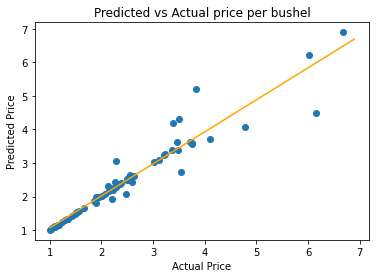

In [13]:
# Calculate a predicted price per bushel from the total dollars paid divided by the total number of bushels
pred_price_bushel = nat_year['PRODUCTION, MEASURED IN $'] / nat_year['PRODUCTION, MEASURED IN BU']

# Calculate linear regression stats
slope, intercept, r_value, p_value, std_err = linregress(nat_year['PRICE RECEIVED, MEASURED IN $ / BU'], pred_price_bushel)

#calculate a range of values to model as the X axis for a best fit line
min_y = pred_price_bushel.min()
max_y = pred_price_bushel.max()
scale = (max_y - min_y) / 5
x_range = np.arange(min_y, max_y+1, scale)

# score the fit
print(r_value)

# plot the data
plt.figure()
plt.scatter(nat_year['PRICE RECEIVED, MEASURED IN $ / BU'], pred_price_bushel)
plt.plot(x_range, slope*x_range+intercept, color='orange')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual price per bushel')
plt.show()

A very high correlation (>95%) is seen between the predicted and actual price recieved per bushel. Thus, this cilumn may be calculated after plotting the target columns `PRODUCTION, MEASURED IN $` and `PRODUCTION, MEASURED IN BU`.

Similar to the excersize above, the acres harvested should be calculable by dividing the `PRODUCTION, MEASURED IN BU` by the `YIELD, MEASURED IN BU / ACRE` columns.

0.9999964115602497


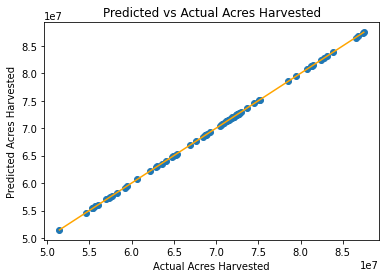

In [14]:
# Calculate a predicted acres harvested from the total number of bushels and bushel per acre columns
pred_acres_harvested = nat_year['PRODUCTION, MEASURED IN BU'] / nat_year['YIELD, MEASURED IN BU / ACRE']

# Calculate linear regression stats
slope, intercept, r_value, p_value, std_err = linregress(nat_year['ACRES HARVESTED'], pred_acres_harvested)

#calculate a range of values to model as the X axis for a best fit line
min_y = pred_acres_harvested.min()
max_y = pred_acres_harvested.max()
scale = (max_y - min_y) / 5
x_range = np.arange(min_y, max_y+1, scale)

# score the fit
print(r_value)

# plot the data
plt.figure()
plt.scatter(nat_year['ACRES HARVESTED'], pred_acres_harvested)
plt.plot(x_range, slope*x_range+intercept, color='orange')
plt.xlabel('Actual Acres Harvested')
plt.ylabel('Predicted Acres Harvested')
plt.title('Predicted vs Actual Acres Harvested')
plt.show()

A near perfect correlation (>99%) is observed here between the actual and predicted acres harvested, implying that this is an excellent way to calculate this feature.

I will now calculate these secondary models in the actual train / test environment. To do this, I will first regenerate my y_test values and turn the y_pred values from the linear regression models into a new data frame.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

y_test

,"PRODUCTION, MEASURED IN BU","PRODUCTION, MEASURED IN $","YIELD, MEASURED IN BU / ACRE","PRICE RECEIVED, MEASURED IN $ / BU",ACRES HARVESTED
26,6289169000,13524134000,88.0,2.15,71506000
27,6505041000,13107420000,90.8,2.02,71614000
48,9758685000,18922084000,134.4,2.20,72589000
22,5579832000,8743036000,97.0,1.57,57513000
30,6639396000,20554147000,91.0,3.11,72961000
51,9502580000,18878819000,138.2,1.89,68768000
7,3045355000,3393496000,48.3,1.11,63065000
59,13067156000,46640936000,164.4,3.75,79490000
34,7672130000,20143883000,106.7,2.63,71897000
70,14182479000,61039005000,172.0,3.50,82467000


In [16]:
# Create a data frame to hold the test values.
y_pred_values_df = pd.DataFrame()

# Iterate through the predicted values for the different target features
for i in range(0,5):
    
    # Put the predicted values for the target feature into a new dataframe
    new_column = pd.DataFrame(y_pred_values[i])
    
    # Concatenate the new data frame with the predicted values data frame
    y_pred_values_df = pd.concat([y_pred_values_df, new_column], axis=1)

# Confirm that the new data frame was created.
y_pred_values_df

,"PRODUCTION, MEASURED IN BU","PRODUCTION, MEASURED IN $","YIELD, MEASURED IN BU / ACRE","PRICE RECEIVED, MEASURED IN $ / BU",ACRES HARVESTED
26,5.710860e+09,1.523063e+10,84.971434,2.657793,6.687419e+07
27,6.006537e+09,1.694288e+10,86.341286,2.280056,6.864765e+07
48,1.061488e+10,3.096921e+10,137.460659,2.406898,7.576376e+07
22,5.544426e+09,5.855165e+09,88.141295,1.232118,6.236110e+07
30,6.176728e+09,2.205377e+10,87.110381,2.773735,6.989254e+07
51,1.064678e+10,2.617123e+10,144.691022,2.073482,7.120290e+07
7,3.725361e+09,3.484049e+09,58.004431,1.025256,6.486084e+07
59,1.292508e+10,4.970358e+10,158.650506,4.344125,8.084594e+07
34,7.932515e+09,1.885480e+10,110.439996,2.664109,7.124483e+07
70,1.308772e+10,4.995278e+10,166.203769,4.078326,8.048502e+07


Now that I have my y data, I can model the `Predicted Price per Bushel` and `Predicted Acres Harvested` using the secondary models explored above.

In [17]:
# Calculate a predicted price per bushel column and add it to the predicted values data frame
y_pred_values_df['Predicted Price per Bushel'] = y_pred_values_df['PRODUCTION, MEASURED IN $'] / y_pred_values_df['PRODUCTION, MEASURED IN BU']

# Calculate a predicted acres harvested column and add it to the predicted values data frame
y_pred_values_df['Predicted Acres Harvested'] = y_pred_values_df['PRODUCTION, MEASURED IN BU'] / y_pred_values_df['YIELD, MEASURED IN BU / ACRE']

# Confirm the data frame was created successfully
y_pred_values_df

,"PRODUCTION, MEASURED IN BU","PRODUCTION, MEASURED IN $","YIELD, MEASURED IN BU / ACRE","PRICE RECEIVED, MEASURED IN $ / BU",ACRES HARVESTED,Predicted Price per Bushel,Predicted Acres Harvested
26,5.710860e+09,1.523063e+10,84.971434,2.657793,6.687419e+07,2.666960,6.720918e+07
27,6.006537e+09,1.694288e+10,86.341286,2.280056,6.864765e+07,2.820739,6.956738e+07
48,1.061488e+10,3.096921e+10,137.460659,2.406898,7.576376e+07,2.917528,7.722121e+07
22,5.544426e+09,5.855165e+09,88.141295,1.232118,6.236110e+07,1.056045,6.290384e+07
30,6.176728e+09,2.205377e+10,87.110381,2.773735,6.989254e+07,3.570461,7.090691e+07
51,1.064678e+10,2.617123e+10,144.691022,2.073482,7.120290e+07,2.458137,7.358283e+07
7,3.725361e+09,3.484049e+09,58.004431,1.025256,6.486084e+07,0.935224,6.422546e+07
59,1.292508e+10,4.970358e+10,158.650506,4.344125,8.084594e+07,3.845513,8.146892e+07
34,7.932515e+09,1.885480e+10,110.439996,2.664109,7.124483e+07,2.376901,7.182647e+07
70,1.308772e+10,4.995278e+10,166.203769,4.078326,8.048502e+07,3.816767,7.874502e+07


The predicted data has now been created successfully. I will now compare this predicted data to the actual values to determine model accuracy.

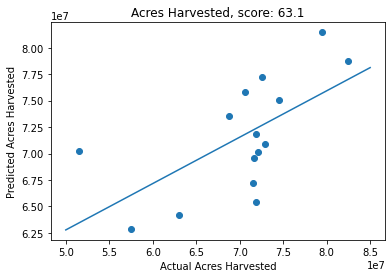

In [19]:
# Calculate linear regression statistics
slope, intercept, r_value, p_value, std_err = linregress(y_test['ACRES HARVESTED'], y_pred_values_df['Predicted Acres Harvested'])

# Create a range of X values for the best fit line
x_range = np.arange(50000000,90000000, 5000000)

# Plot the data with a score for the fit in the title
plt.figure()
plt.scatter(y_test['ACRES HARVESTED'], y_pred_values_df['Predicted Acres Harvested'])
plt.plot(x_range, slope*x_range + intercept)
plt.title(f"Acres Harvested, score: {round(r_value*100,1)}")
plt.xlabel('Actual Acres Harvested')
plt.ylabel('Predicted Acres Harvested')
plt.show()

The scores obtained with these secondary models are still low. Only a 79.3% accuracy is obtained for the price per bushel, and a very low 63.1% accuracy score is obtained for the acres harvested. However, these are the best values found from these models. Further, from a financial perspective, acres harvested is not a target feature of significant interest.

I will now see how close my average prediction for the test data are to the true value.

In [20]:
# Calculate a list of ratios comparing the predicted values to the actual values
y_test_accuracy = (y_test['PRICE RECEIVED, MEASURED IN $ / BU'] / y_pred_values_df['Predicted Price per Bushel']).values

# Find the mean and standard deviation of the ratios
y_test_accuracy_mean = y_test_accuracy.mean()
y_test_accuracy_st_dev = y_test_accuracy.std()

# Print the ratios
print(y_test_accuracy_mean, y_test_accuracy_st_dev)

0.9759521745157931 0.23249833732332506


This model is centered close to 1 (has an average close to 1), which is good. However, it has a large standard deviation, meaning that any prediction is only going to be accurate to within approxiamatly plus or minus 23%.

# Combining the Month Model

I will now combine these results with the monthly corn model obtained in the notebook `National Month Initial Model` to see how well I can predict monthly prices.

I will import the monthly corn data and the monthly variance data frame.

In [21]:
# Import the data frame
monthly_deviations = pd.read_csv('./monthly_deviations.csv', index_col=0)
nat_mon = pd.read_csv('./nat_month.csv', index_col=0)

# Confirm the imports were successful
display(monthly_deviations, nat_mon.head())

,"PRICE RECEIVED, MEASURED IN $ / BU",Month
new_index,,
1,-0.016211,January
2,-0.003748,February
3,0.006983,March
4,0.018128,April
5,0.031111,May
6,0.036755,June
7,0.031000,July
8,0.014387,August
9,-0.013239,September


,Year,Month Number,"PRICE RECEIVED, MEASURED IN $ / BU",Precipitation,Average Temperature,month_cos,month_sin
0,1950,1,1.15,4.80035,39.17000,8.660254e-01,0.500000
1,1950,2,1.16,3.85875,40.80717,5.000000e-01,0.866025
2,1950,3,1.19,2.57250,45.28000,6.123234e-17,1.000000
3,1950,4,1.26,1.28625,51.39000,-5.000000e-01,0.866025
4,1950,5,1.34,0.34465,57.50000,-8.660254e-01,0.500000


The imports were successful. I now want to try to predict monthly prices for both my train and test years. To do this, I will need to seperate the monthly data into train and test sets by matching them to the years in the `y_train` and `y_pred_values_df` data frames.

In [22]:
# For convenience, I will add year columns to the y_pred_values_df and y_train data frames
y_pred_values_df['Year'] = y_pred_values_df.index + 1950
y_train['Year'] = y_train.index + 1950

# Confirm year added successfully
display(y_pred_values_df.head(), y_train.head())

test_years = y_pred_values_df['Year'].values
test_years

,"PRODUCTION, MEASURED IN BU","PRODUCTION, MEASURED IN $","YIELD, MEASURED IN BU / ACRE","PRICE RECEIVED, MEASURED IN $ / BU",ACRES HARVESTED,Predicted Price per Bushel,Predicted Acres Harvested,Year
26,5.710860e+09,1.523063e+10,84.971434,2.657793,6.687419e+07,2.666960,6.720918e+07,1976
27,6.006537e+09,1.694288e+10,86.341286,2.280056,6.864765e+07,2.820739,6.956738e+07,1977
48,1.061488e+10,3.096921e+10,137.460659,2.406898,7.576376e+07,2.917528,7.722121e+07,1998
22,5.544426e+09,5.855165e+09,88.141295,1.232118,6.236110e+07,1.056045,6.290384e+07,1972
30,6.176728e+09,2.205377e+10,87.110381,2.773735,6.989254e+07,3.570461,7.090691e+07,1980


,"PRODUCTION, MEASURED IN BU","PRODUCTION, MEASURED IN $","YIELD, MEASURED IN BU / ACRE","PRICE RECEIVED, MEASURED IN $ / BU",ACRES HARVESTED,Year
55,11112187000,22194287000,147.9,1.96,75117000,2005
69,13619928000,48940622000,167.5,3.75,81337000,2019
62,10755111000,74155299000,123.1,6.67,87365000,2012
43,6337730000,16035515000,100.7,2.50,62933000,1993
4,2707913000,3872433000,39.4,1.43,68668000,1954


array([1976, 1977, 1998, 1972, 1980, 2001, 1957, 2009, 1984, 2020, 2006,
       1978, 1981, 1992, 1983], dtype=int64)

The year columns were added successfully. I will now need to make a filter for determining which years belong to the test data frame and which belong to the train data frame. Since all years belong to either one or the other, I can just filter for years that belong to one data frame and use that to sort the data.

In [23]:
# Create a list of years belonging to the test data frame
train_years = y_train['Year'].values

# Confirm list created successfully
train_years

array([2005, 2019, 2012, 1993, 1954, 2015, 2000, 1952, 1990, 1961, 1953,
       2004, 1995, 1960, 1991, 1999, 2003, 2007, 1982, 1964, 2018, 1969,
       1979, 2002, 1985, 1968, 1950, 1965, 1955, 1966, 1970, 2016, 1958,
       1963, 1975, 1987, 1967, 2010, 1996, 2013, 1989, 1988, 1951, 2008,
       1962, 2011, 1974, 1956, 1973, 1986, 1971, 1959, 2017, 2014, 1997,
       1994], dtype=int64)

I now have my filter list. I will now use this to seperate the monthly data into train and test sets.

In [24]:
# Create data frames to store the train and test data
nat_mon_train = pd.DataFrame(columns=['Year', 'Month Number', 'PRICE RECEIVED, MEASURED IN $ / BU'])
nat_mon_test = pd.DataFrame(columns=['Year', 'Month Number', 'PRICE RECEIVED, MEASURED IN $ / BU'])

# Iterate through each row of the monthly data
for row in nat_mon.index:
    
    # Check to see if the year in that row belongs to the test data
    if nat_mon['Year'][row] in test_years:
        
        # If the year belongs to the test data, append the data to the test data frame.
        # Note: the only features of interest are 'Year', 'Month Number', 'PRICE RECEIVED, MEASURED IN $ / BU'.
        nat_mon_test = nat_mon_test.append(nat_mon.iloc[[row]].drop(columns=['Precipitation', 'Average Temperature', 'month_cos', 'month_sin']))
    
    else:
        
        # If the year does not belong to the test data, it must belong to the train data.
        # Append the row of data to the train data frame.
        nat_mon_train = nat_mon_train.append(nat_mon.iloc[[row]].drop(columns=['Precipitation', 'Average Temperature', 'month_cos', 'month_sin']))
        
# Create columns to store predicted prices.
# Set the column equal to 0.0 to make the columns type = float.
nat_mon_train['Predicted Price Recieved'] = 0.0
nat_mon_test['Predicted Price Recieved'] = 0.0

# Confirm train and test data frames were created successfully.
display(nat_mon_train.head(), nat_mon_test.head())

,Year,Month Number,"PRICE RECEIVED, MEASURED IN $ / BU",Predicted Price Recieved
0,1950,1,1.15,0.0
1,1950,2,1.16,0.0
2,1950,3,1.19,0.0
3,1950,4,1.26,0.0
4,1950,5,1.34,0.0


,Year,Month Number,"PRICE RECEIVED, MEASURED IN $ / BU",Predicted Price Recieved
84,1957,1,1.23,0.0
85,1957,2,1.19,0.0
86,1957,3,1.20,0.0
87,1957,4,1.21,0.0
88,1957,5,1.23,0.0


The monthly data has been split into train and test data frames. I will now calculate and add the predicted prices to these dataframes.

In [25]:
# Iterate through each row of the training data frame
for row in nat_mon_train.index:
    
    # Get the year in the row
    yr = nat_mon_train['Year'][row]
    
    # Get the month in the row
    month = nat_mon_train['Month Number'][row] 
    
    # Find the index corresponding to the given year in the y_train data frame.
    ind = y_train.loc[y_train['Year'] == yr].index[0]
    
    # Use the ind value to find the annual price recieved
    price_per_bushel = y_train['PRICE RECEIVED, MEASURED IN $ / BU'][ind]
    
    # Use the month value to find how much the annual price should be adjusted for the given month
    month_correction = monthly_deviations['PRICE RECEIVED, MEASURED IN $ / BU'][month]
    
    # Calculate the monthly price recieved and add it to the data frame
    nat_mon_train['Predicted Price Recieved'][row] = price_per_bushel * (1+month_correction)
    
# Check that the data frame has been populated
display(nat_mon_train.head())

,Year,Month Number,"PRICE RECEIVED, MEASURED IN $ / BU",Predicted Price Recieved
0,1950,1,1.15,1.495359
1,1950,2,1.16,1.514303
2,1950,3,1.19,1.530614
3,1950,4,1.26,1.547555
4,1950,5,1.34,1.567289


The predicted values for the training data frame have been created. I will now do the same for the test data, except here I will be predicting monthly prices from annual prices modeled using a secondary model. Thus, this result will correspond to a model based on a model that is based on another model, i.e. a tertiary model.

In [26]:
# Iterate through each row of the test data frame
for row in nat_mon_test.index:
    
    # Get the year in the row
    yr = nat_mon_test['Year'][row]
    
    # Get the month in the row
    month = nat_mon_test['Month Number'][row] 
    
    # Find the index corresponding to the given year in the y_train data frame.
    ind = y_pred_values_df.loc[y_pred_values_df['Year'] == yr].index[0]
    
    # Use the ind value to find the annual price recieved
    price_per_bushel = y_pred_values_df['PRICE RECEIVED, MEASURED IN $ / BU'][ind]
    
    # Use the month value to find how much the annual price should be adjusted for the given month
    month_correction = monthly_deviations['PRICE RECEIVED, MEASURED IN $ / BU'][month]
    
    # Calculate the monthly price recieved and add it to the data frame
    nat_mon_test['Predicted Price Recieved'][row] = price_per_bushel * (1+month_correction)
    
# Check that the data frame has been populated
display(nat_mon_test.head())

,Year,Month Number,"PRICE RECEIVED, MEASURED IN $ / BU",Predicted Price Recieved
84,1957,1,1.23,1.008635
85,1957,2,1.19,1.021414
86,1957,3,1.20,1.032416
87,1957,4,1.21,1.043842
88,1957,5,1.23,1.057153


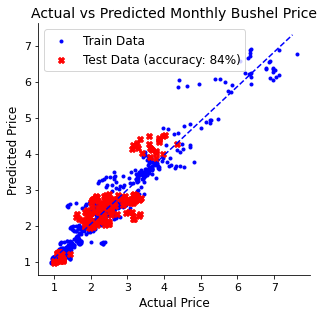

In [163]:
# Calculate linear regression stats for the train data
slope_train, intercept_train, r_value_train, p_value, std_err = linregress(nat_mon_train['PRICE RECEIVED, MEASURED IN $ / BU'], nat_mon_train['Predicted Price Recieved'])

# Calculate linear regression stats for the test data
slope_test, intercept_test, r_value_test, p_value, std_err = linregress(nat_mon_test['PRICE RECEIVED, MEASURED IN $ / BU'], nat_mon_test['Predicted Price Recieved'])

# Generate a range of x values for the best fit line
x_range = np.arange(1,8,0.5)


plt.figure(figsize=(4.5,4.5))

# Train data plot
plt.scatter(
    nat_mon_train['PRICE RECEIVED, MEASURED IN $ / BU'], 
    nat_mon_train['Predicted Price Recieved'], 
    color='blue', 
    label="Train Data", 
    marker='.')

# Test data plot
plt.scatter(
    nat_mon_test['PRICE RECEIVED, MEASURED IN $ / BU'], 
    nat_mon_test['Predicted Price Recieved'], 
    color='red', 
    label="Test Data (accuracy: 84%)", 
    marker='X')

# plot the best fit lines
# train
plt.plot(x_range, slope_train*x_range + intercept_train, color='blue', ls='--')

plt.legend()
plt.title('Actual vs Predicted Monthly Bushel Price', size=14)
plt.xlabel('Actual Price', size=12)
plt.ylabel('Predicted Price', size=12)
plt.xticks(size=11)
plt.yticks(size=11)
plt.legend(fontsize=12)

sns.despine()
plt.tight_layout()
plt.savefig('./ac_pred_mppb.png', dpi=180)
plt.show()

The scores obtained for the train and test data for this model are encouraging. The train model can account for about 97.3% of the variance in the data, whereas the test model can only account for about 86.6% of the variance. I will now see how close my average prediction for the test data are to the true value.

In [28]:
# Calculate a list of ratios comparing the predicted values to the actual values
nat_mon_test_results = (nat_mon_test['PRICE RECEIVED, MEASURED IN $ / BU'] / 
    nat_mon_test['Predicted Price Recieved']).values

# Find the mean and standard deviation of the ratios
nat_mon_test_mean = nat_mon_test_results.mean()
nat_mon_test_dev = nat_mon_test_results.std()

# Print the ratios
print(nat_mon_test_mean, nat_mon_test_dev)

0.9938642770133489 0.15901005404714882


This model is centered almost exactly at 1 (average = 0.99) with a standard deviation of about 16%. Thus, this model can accurately predict the monthly sales price of grain corn to within plus or minus 16% of the real value. This means I can calculate monthly sales prices much more accurately than annual average sales prices.

In [29]:
# Find the max and min sales price of grain corn
max_price = nat_mon['PRICE RECEIVED, MEASURED IN $ / BU'].max()
min_price = nat_mon['PRICE RECEIVED, MEASURED IN $ / BU'].min()

print(f"Max: {max_price}, Min: {min_price}")

# Find the max and min sales price of grain corn
max_price_2000 = nat_mon.loc[nat_mon['Year'] >= 2000]['PRICE RECEIVED, MEASURED IN $ / BU'].max()
min_price_2000 = nat_mon.loc[nat_mon['Year'] >= 2000]['PRICE RECEIVED, MEASURED IN $ / BU'].min()

print(f"Since 2000, Max: {max_price_2000}, Min: {min_price_2000}")

Max: 7.63, Min: 0.902
Since 2000, Max: 7.63, Min: 1.52


In the last 20 years, grain corn sales prices have ranged from as low as \\$1.52 to as high as \\$7.63 a bushel. This is a wide range of price values. Being able to predict the price of this corn to within about 16% of the actual sales price will greatly reduce investment risks for this comodity.

This is the end of this notebook.

In [64]:
# Creating the new column. I am setting all values equal to 0.0 to set the column type as a float.
nat_year['Previous_Year_Price_Recieved'] = 0.0

# Populating column.
# Note: I have to start with the second row, as the price recieved in the year prior to 1950 is not available.
# Thus, the value for this column for the year 1950 will be 0.
for ind in range(1,71):
    nat_year['Previous_Year_Price_Recieved'][ind] = nat_year['PRICE RECEIVED, MEASURED IN $ / BU'][ind - 1]
    
# Confirm the column was created successfully.
nat_year.head()

,Year,"PRICE RECEIVED, MEASURED IN $ / BU",ACRES HARVESTED,"PRODUCTION, MEASURED IN BU","YIELD, MEASURED IN BU / ACRE","PRODUCTION, MEASURED IN $",Cooling Degree Days,Heating Degree Days,Precipitation,Palmer Drought Severity Index (PDSI),Palmer Hydrological Drought Index (PHDI),Palmer Modified Drought Index (PMDI),Average Temperature,Maximum Temperature,Minimum Temperature,Palmer Z-Index,USPop,Previous_Year_Price_Recieved
0,1950,1.52,72398000,2764071000,38.2,4222366000,263,14,30.87,1.93,1.93,1.93,51.39,63.61,39.17,4.14,152270000,0.00
1,1951,1.66,71191000,2628937000,36.9,4364659000,314,9,31.25,1.65,1.65,1.65,51.12,63.19,39.04,0.80,154880000,1.52
2,1952,1.52,71353000,2980793000,41.8,4557031000,355,6,26.34,-1.84,-1.84,-1.84,52.27,64.70,39.85,-2.32,157550000,1.66
3,1953,1.48,70738000,2881801000,40.7,4291366000,330,7,28.31,-1.76,-1.76,-0.88,53.37,65.76,40.96,-0.43,160180000,1.52
4,1954,1.43,68668000,2707913000,39.4,3872433000,349,10,26.15,-4.33,-4.33,-4.33,53.33,65.78,40.87,-2.76,163030000,1.48


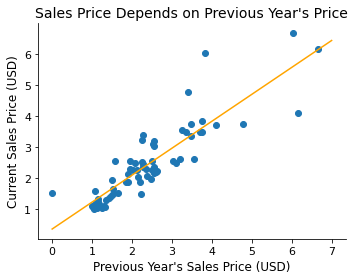

0.8858239474289384


In [80]:
# Calculate linear regression stats for the plot
slope, intercept, r_value, p_value, std_err = linregress(nat_year['Previous_Year_Price_Recieved'], nat_year['PRICE RECEIVED, MEASURED IN $ / BU'])
x_range = np.arange(0,8)

plt.figure(figsize=(5,4))
plt.scatter(X['Previous_Year_Price_Recieved'], y['PRICE RECEIVED, MEASURED IN $ / BU'])
plt.plot(x_range, slope*x_range + intercept, color='orange')
plt.xlabel('Previous Year\'s Sales Price (USD)', size=12)
plt.ylabel('Current Sales Price (USD)', size=12)
plt.title('Sales Price Depends on Previous Year\'s Price', size=14)
plt.xticks(size=11)
plt.yticks(size=11)
sns.despine()
plt.tight_layout()
plt.savefig('./price_last.png', dpi=180)
plt.show()
print(r_value)

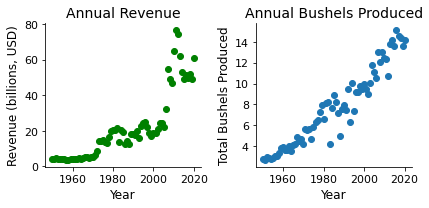

0.8858239474289384


In [161]:
# Calculate linear regression stats for the plot
plt.subplots(2, figsize=(6,3))


plt.subplot(1,2,2)
plt.scatter(nat_year['Year'], nat_year['PRODUCTION, MEASURED IN BU'] / 1000000000)
plt.xlabel('Year', size=12)
plt.ylabel('Total Bushels Produced', size=12)
plt.title('Annual Bushels Produced', size=14)
plt.xticks(size=11)
plt.yticks(size=11)
sns.despine()
plt.tight_layout()


slope, intercept, r_value, p_value, std_err = linregress(nat_year['Previous_Year_Price_Recieved'], nat_year['PRICE RECEIVED, MEASURED IN $ / BU'])
x_range = np.arange(1950,2021)

plt.subplot(1,2,1)
plt.scatter(nat_year['Year'], nat_year['PRODUCTION, MEASURED IN $'] / 1000000000, color='green')
plt.xlabel('Year', size=12)
plt.ylabel('Revenue (billions, USD)', size=12)
plt.title('Annual Revenue', size=14)
plt.xticks(size=11)
plt.yticks(size=11)
sns.despine()
plt.tight_layout()

plt.savefig('./yield_revenue.png', dpi=180)
plt.show()
print(r_value)

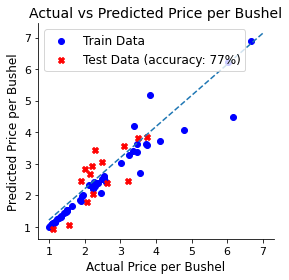

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

y_train

y_train['Predicted Price per Bushel'] = y_train['PRODUCTION, MEASURED IN $'] / y_train['PRODUCTION, MEASURED IN BU']

# Calculate linear regression statistics
slope, intercept, r_value, p_value, std_err = linregress(y_test['PRICE RECEIVED, MEASURED IN $ / BU'], y_pred_values_df['Predicted Price per Bushel'])

# Create a range of X values for the best fit line
x_range = np.arange(1,8)

# Plot the data with a score for the fit in the title
plt.figure(figsize=(4,4))

plt.scatter(
    y_train['PRICE RECEIVED, MEASURED IN $ / BU'], 
    y_train['Predicted Price per Bushel'],
    marker="o",
    color='blue',
    label='Train Data'
)

plt.scatter(
    y_test['PRICE RECEIVED, MEASURED IN $ / BU'],
    y_pred_values_df['Predicted Price per Bushel'],
    marker="X",
    color='red',
    label=f'Test Data (accuracy: {round(77,1)}%)'
)

plt.plot(x_range, slope*x_range + intercept, ls='--')

plt.title("Actual vs Predicted Price per Bushel", size=14)
plt.xlabel('Actual Price per Bushel', size=12)
plt.ylabel('Predicted Price per Bushel', size=12)
plt.xticks(size=11)
plt.yticks(size=11)
plt.legend(fontsize=12)

sns.despine()
plt.tight_layout()
plt.savefig('./ac_pred_ppb.png', dpi=180)
plt.show()